In [1]:
import os
import re
import dotenv
import numpy as np
from numpy import inf
import pandas as pd
from pprint import pprint

# library for save and load scikit-learn models
import pickle

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import dtreeviz

import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [19]:
X = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/X_decision_trees.csv', encoding='utf-8')
y = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/y_both.csv', encoding='utf-8')
y_log = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/y_log_both.csv', encoding='utf-8')

In [20]:
X = X.set_index('ID')
y = y.set_index('ID')
y_log = y_log.set_index('ID')

In [21]:
print(X.head())
print(y.head())

                                  has_any_image  hashtags_count  \
ID                                                                
urn:li:share:7015109880122384384          False               6   
urn:li:share:7015180072244367361           True               3   
urn:li:share:7015210047886524416           True               0   
urn:li:share:7015240414274158592           True               0   
urn:li:share:7015572647832948736           True               0   

                                  has_any_hashtag  week_posted  \
ID                                                               
urn:li:share:7015109880122384384             True           52   
urn:li:share:7015180072244367361             True           52   
urn:li:share:7015210047886524416            False           52   
urn:li:share:7015240414274158592            False           52   
urn:li:share:7015572647832948736            False            1   

                                  weekday_posted  day_posted  hour_

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42, stratify=X['fanpage_id'])

In [24]:
X_train = X_train.drop(columns=['fanpage_id'])
X_test = X_test.drop(columns=['fanpage_id'])
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [25]:
# fit the regressor
reg = tree.DecisionTreeRegressor(random_state=42)

In [26]:
warnings.filterwarnings("ignore")
scorer = make_scorer(r2_score)
param_grid = {
    'max_depth': [4, 6, 8, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 4, 6, 8, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6]  # Minimum number of samples required to be a leaf node
}

grid_search = GridSearchCV(reg, param_grid, cv=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Find the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [27]:
print(best_params)

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [11]:
y_test

ID
urn:li:share:7062390620459278336      0.023813
urn:li:share:7041665346704953344      0.052863
urn:li:share:7087748074210480128      0.026060
urn:li:ugcPost:7034413400247959552    0.027629
urn:li:share:7041389649491066880      0.025339
                                        ...   
urn:li:ugcPost:7046465420832186368    0.209723
urn:li:ugcPost:7080032059519373312    0.288893
urn:li:share:7070668176014909440      0.015152
urn:li:share:7085007478261731328      0.054645
urn:li:share:7044002710832001024      0.020377
Name: eng_rate, Length: 673, dtype: float64

In [28]:
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Train R-squared: {train_score:.2f}")
print(f"Test R-squared: {test_score:.2f}")

Train R-squared: 0.19
Test R-squared: 0.19


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score, explained_variance_score

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmsle = mean_squared_log_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)',
                                      'Root Mean Squared Error (RMSE)', 'Root Mean Squared Logarithmic Error (RMSLE)',
                                      'R-squared (R^2)', 'Explained Variance Score'],
                            'Value': [mae, mse, rmse, rmsle, r2, explained_variance]})

In [30]:
metrics_df

,Metric,Value
0,Mean Absolute Error (MAE),0.097066
1,Mean Squared Error (MSE),0.017058
2,Root Mean Squared Error (RMSE),0.130605
3,Root Mean Squared Logarithmic Error (RMSLE),0.007206
4,R-squared (R^2),0.187220
5,Explained Variance Score,0.187733


In [26]:
# plot the tree
viz_model = dtreeviz.model(
    best_model,
    X_train=X_train,
    y_train=y_train,
    target_name='eng_rate',
    feature_names=X_train.columns
)
v = viz_model.view()     # render as SVG into internal object 
v.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

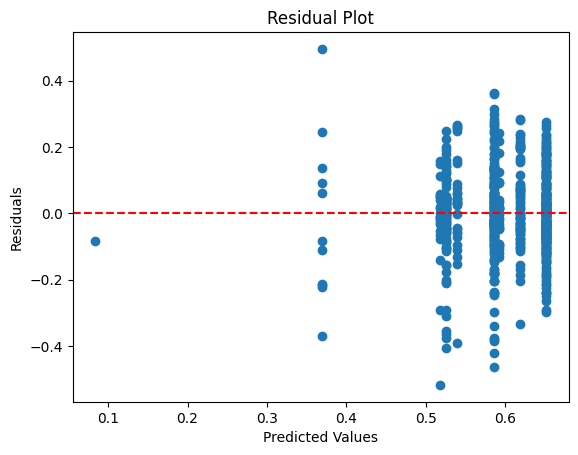

In [31]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

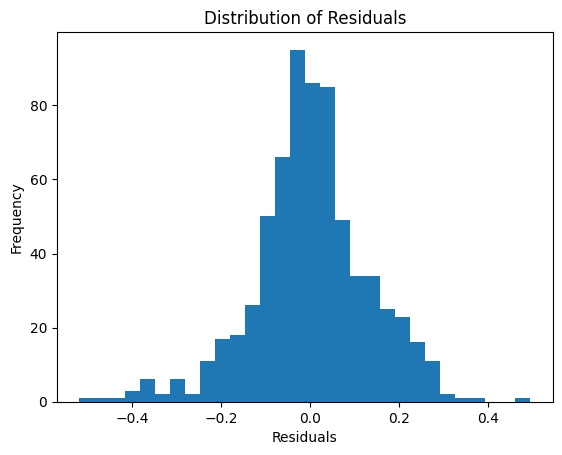

In [32]:
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

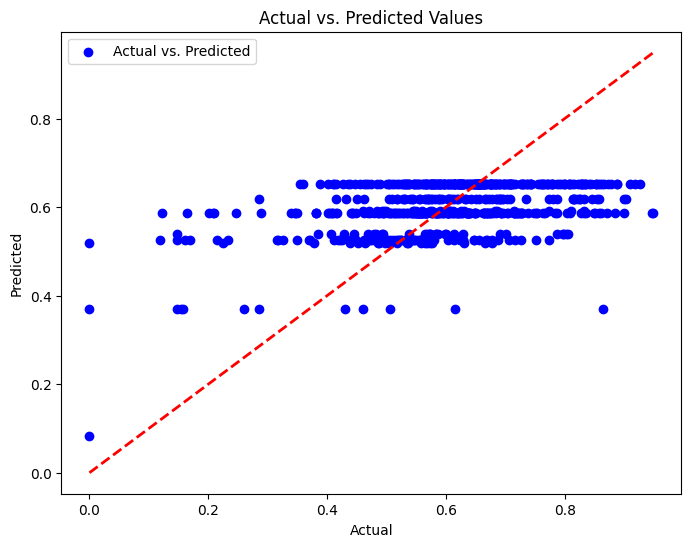

In [33]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [34]:
# Save the model
with open(os.path.join('/home/jovyan/git_projects/machine-learning-project/models', 'decision_tree_model.pkl'), 'wb') as f:
    pickle.dump(best_model, f)